# Exploring ODF Extraction - Data Analysis
## Sam Potter
## Current: 4/10/19

## Path and Imports

In [1]:
import sys
import os

# psfdi
sys.path.extend(['C:\\Users\\potterst1\\Desktop\Repositories\BitBucket\psfdi',
                 'C:/Users/potterst1/Desktop/Repositories/BitBucket/psfdi'])
sys.path.extend(['/workspace/stpotter/git/bitbucket/psfdi'])

from psfdi import visualize
from psfdi import fileIO
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
from matplotlib import rc
from psfdi import utilities
from psfdi import odf
import seaborn as sns
import cv2
import matplotlib

from ipywidgets import *
from scipy import optimize as sciopt
from scipy.stats import beta
from scipy.stats import sem

## Magics

In [2]:
%matplotlib inline

# Look at ODF data from SALS and compare with pSFDI a0, a2, a4

## Load Processed pSFDI Data

### Load in pSFDI Data

In [3]:
pSFDI_data_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\3.24.19b\\2) pSFDI\\V_Green\data_proc.mat'
pSFDI_data = fileIO.read_mat_file(pSFDI_data_path)

phi = pSFDI_data['phi_DC'][:, :, 0]
a0 = pSFDI_data['a0_DC'][:, :, 0]
a2 = pSFDI_data['a2_DC'][:, :, 0]
a4 = pSFDI_data['a4_DC'][:, :, 0]
DOA = pSFDI_data['DOA_DC'][:, :, 0]

# Add 180
phi = phi + 180 * np.ones(phi.shape)

### Visualize data

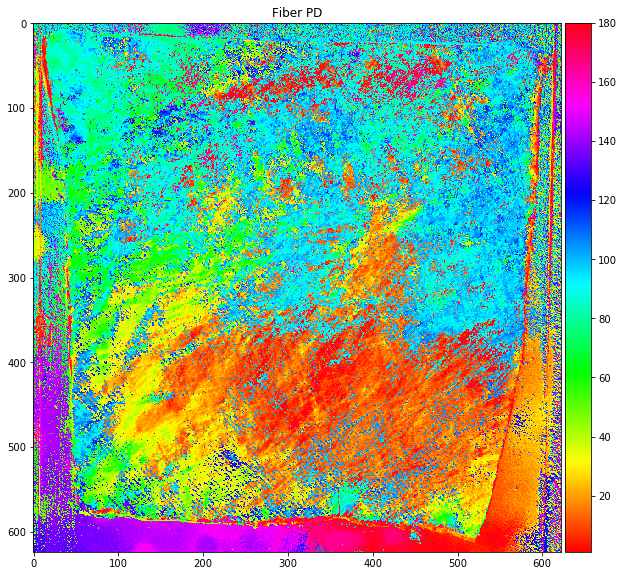

In [4]:
# PD
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(phi, cmap='hsv');
plt.title('Fiber PD');
ax = plt.gca();
divider = make_axes_locatable(ax);
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im0, cax=cax);

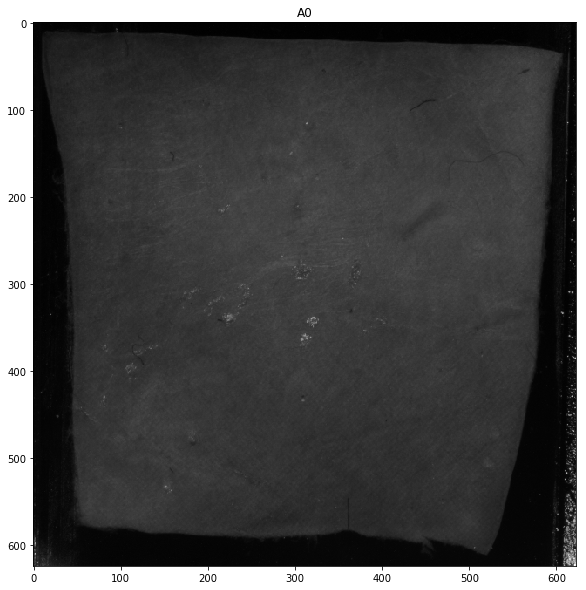

In [5]:
# a0
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(a0, cmap='gray')
plt.title('A0');

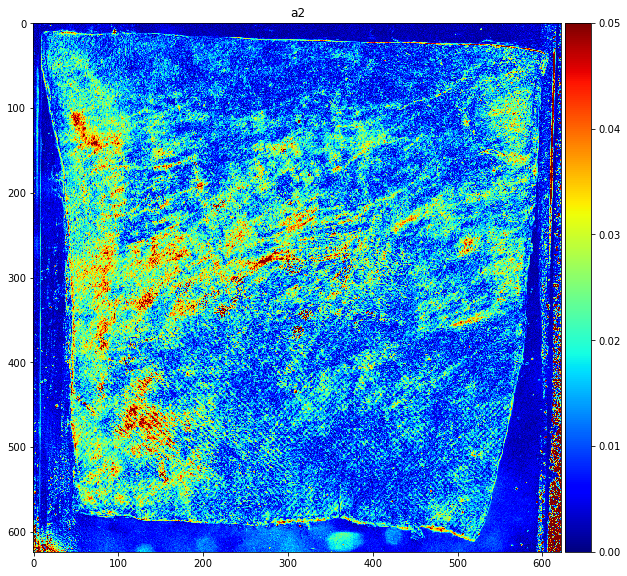

In [6]:
# a2
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(a2, cmap='jet')
plt.title('a2')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (0, 0.05);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

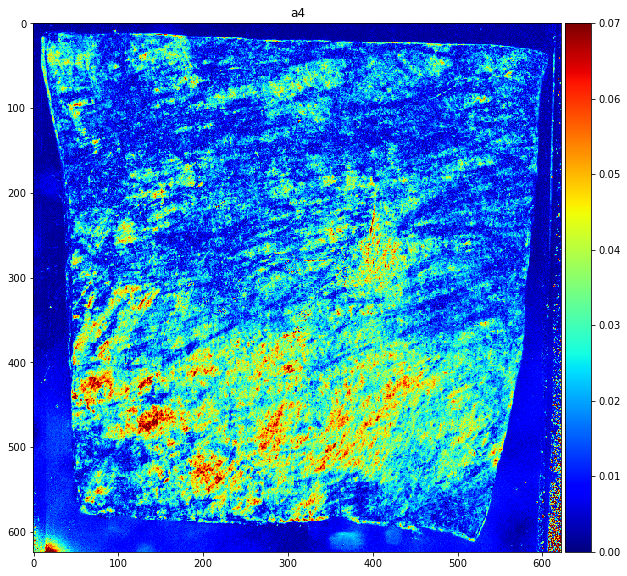

In [7]:
# a4
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(a4, cmap='jet')
plt.title('a4')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (0, 0.07);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

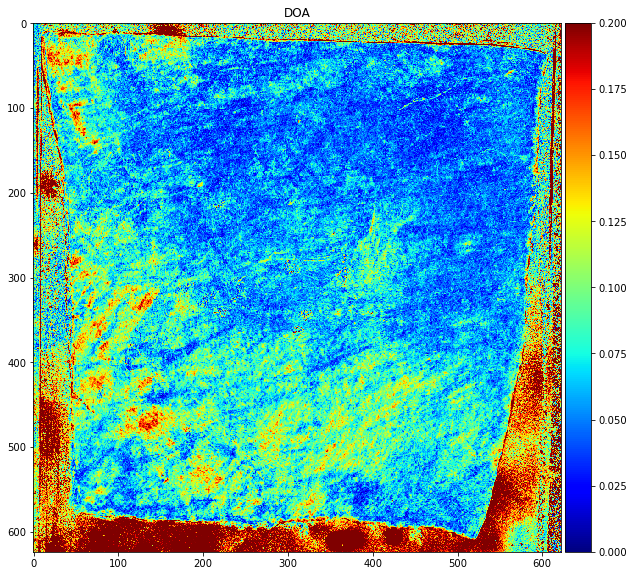

In [8]:
# DOA
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(DOA, cmap='jet')
plt.title('DOA')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (0, .2);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

### Visualize a2/a4 ratio

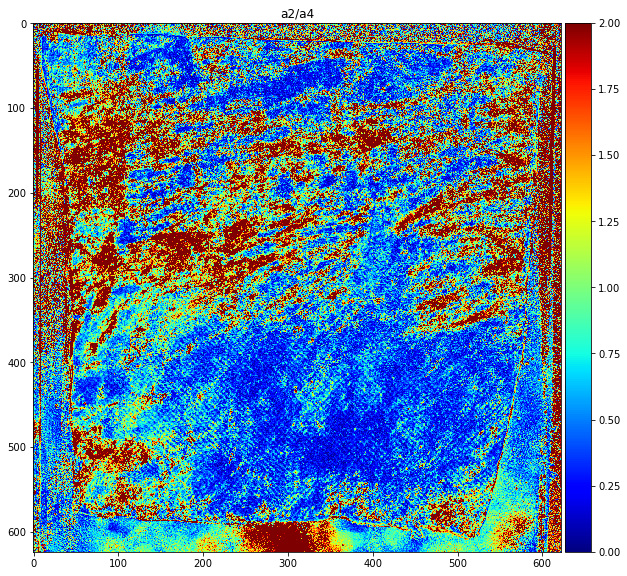

In [9]:
a2a4 = a2/a4
# a2/a4
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(a2a4, cmap='jet')
plt.title('a2/a4')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (0, 2);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

## Load Raw Intensity pSFDI Data

### Specify file paths

In [10]:
sample_data_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\3.24.19b\\2) pSFDI\\Sample\\Vertical\\Green'
standard_data_path = 'C:\\Users\\potterst1\\Box Sync\\Research\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\3.24.19b\\1) Standard\\Standard\\Vertical\\Green'

### Load mask

In [11]:
xrange, yrange = fileIO.read_psfdi_mask(sample_data_path)

### Specify spatial frequency and polarizer resolution

In [12]:
sfx_per = 37.8363
polar_res = 9
polar_max = 180
polar_angles = np.arange(0, 180, polar_res)

### Load and crop sample no sfx images

In [13]:
sample_dark = fileIO.read_no_sfx(sample_data_path, xrange, yrange, polar_res, polar_max, 'dark')
sample_planar = fileIO.read_no_sfx(sample_data_path, xrange, yrange, polar_res, polar_max, 'planar')

### Load and crop sample sfx images

In [22]:
sample_I0 = fileIO.read_sfx(sample_data_path, xrange, yrange, polar_res, polar_max, sfx_per, 0)
sample_I120 = fileIO.read_sfx(sample_data_path, xrange, yrange, polar_res, polar_max, sfx_per, 120)
sample_I240 = fileIO.read_sfx(sample_data_path, xrange, yrange, polar_res, polar_max, sfx_per, 240)

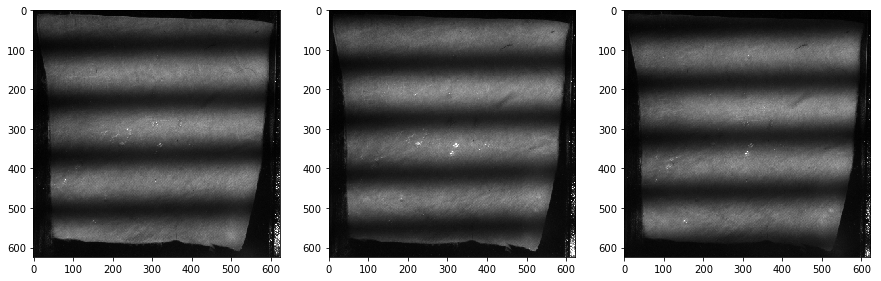

In [30]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 15))
ax0.imshow(sample_I0[0, :, :], cmap='gray');
ax1.imshow(sample_I120[0, :, :], cmap='gray');
ax2.imshow(sample_240[0, :, :], cmap='gray');

### Load and crop standard images

### Median filter standard and dark images

### Demodulate Images

In [ ]:
# DC images
sample_IDC = [(sample_I0[angle, :, :] + sample_I120[angle, :, :] + sample_I240[angle, :, :]) / 3 for angle in range(int(180 / polar_res))]
sample_IDC = np.array(sample_IDC)

# AC images
sample_IAC = [np.sqrt(2*(np.square(sample_I0[angle, :, :] - sample_I120[angle, :, :]) + np.square(sample_I120[angle, :, :] - sample_I240[angle, :, :]) + np.square(sample_I240[angle, :, :] - sample_I0[angle, :, :])) / 3) for angle in range(int(180 / polar_res))]
sample_IAC = np.array(sample_IAC)

### Subtract out dark images

## Load in SALS data

In [ ]:
SALS_data_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\SALS\\Results\\BP ODF 032919\\SALSA OUT TXT\\BP_ODF_Extraction_032919_SALSA.txt'

with open(SALS_data_path) as f:
    SALS_data = [line.rstrip('\n') for line in f]

In [ ]:
# Parse the data
header_string = SALS_data[0]

In [ ]:
# Split the data into individual parts
SALS_string_data = SALS_data[1:-1:6]
SALS_intensity_data = SALS_data[2:-1:6]
SALS_odd_data = SALS_data[3:-1:6]
SALS_odf_data = SALS_data[4:-1:6]
SALS_theta_data = SALS_data[5:-1:6]

In [ ]:
# Manually parse data
# split SALS data
SALS_string_list = [line.split('\t') for line in SALS_string_data]

# Get variables of interest
SALS_PD = [row[2] for row in SALS_string_list]
SALS_SD = [row[6] for row in SALS_string_list]
x = [row[0] for row in SALS_string_list]
y = [row[1] for row in SALS_string_list]

# Convert strings to floats
SALS_PD = list(map(float, SALS_PD[0:]))
SALS_SD = list(map(float, SALS_SD[0:]))
x = list(map(float, x[0:]))
y = list(map(float, y[0:]))

# Convert lists to numpy arrays
SALS_PD = np.array(SALS_PD)
SALS_SD = np.array(SALS_SD)
x = np.array(x)
y = np.array(y)

In [ ]:
# Reshape the data
y_step = y[1] - y[0]
ydim = int(np.max(y) / y_step + 1)
xdim = int(len(y) / ydim)

x_2d = np.reshape(x, (xdim, ydim)).T
y_2d = np.reshape(y[::-1], (xdim, ydim)).T
PD_2d = np.reshape(SALS_PD, (xdim, ydim)).T
PD_2d = np.rad2deg(PD_2d)  # Convert radians to degrees
SD_2d = np.reshape(SALS_SD, (xdim, ydim)).T
SD_2d = np.rad2deg(SD_2d)  # Convert radians to degrees

In [ ]:
# Reshape theta based data
# Split strings
SALS_intensity_list = [line.split(';') for line in SALS_intensity_data]
SALS_odd_list = [line.split(';') for line in SALS_odd_data]
SALS_odf_list = [line.split(';') for line in SALS_odf_data]
SALS_theta_list = [line.split(';') for line in SALS_theta_data]

# Strings to floats
SALS_intensity = [list(map(float, row[:-1])) for row in SALS_intensity_list]
SALS_odd = [list(map(float, row[:-1])) for row in SALS_odd_list]
SALS_odf = [list(map(float, row[:-1])) for row in SALS_odf_list]
SALS_theta = [list(map(float, row[:-1])) for row in SALS_theta_list]

In [ ]:
# Convert to numpy arrays
SALS_intensity = np.array(SALS_intensity)
SALS_odd = np.array(SALS_odd)
SALS_odf = np.array(SALS_odf)
SALS_theta = np.array(SALS_theta)

In [ ]:
# SALS PD
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(PD_2d, cmap='hsv')
plt.title('SALS PD')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (0, 180);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

In [ ]:
# SALS SD
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(SD_2d, cmap='jet')
plt.title('SALS SD')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (45, 55);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

In [ ]:
# Save a file for masking a mask
name = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\SALS\\Results\\BP ODF 032919\\BW_Images\\color_premask.png'
plt.imsave(name, SD_2d, format='png', cmap='jet', vmin=45, vmax=55)

## Compare pSFDI and SALS

### Resample images

In [ ]:
# Binary mask of pSFDI image
psfdi_mask_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\3.24.19b\\2) pSFDI\\V_Green\mask.tif'
psfdi_mask = cv2.imread(psfdi_mask_path, -1)

# Binary mask of SALS image
sals_mask_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\SALS\\Results\\BP ODF 032919\\BW_Images\\Mask.tif'
sals_mask = cv2.imread(sals_mask_path, -1)

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15))
im0 = ax0.imshow(psfdi_mask, cmap='gray')
ax0.set_title('Data Mask for pSFDI Imaging');

im1 = ax1.imshow(sals_mask, cmap='gray')
ax1.set_title('Data Mask for SALS Imaging');

In [ ]:
# upscale the psfdi data
# set the size of the upscaling
sals_rows, sals_columns = sals_mask.shape
psfdi_rows, psfdi_columns = psfdi_mask.shape

row_step = int(psfdi_rows / sals_rows)
col_step = int(psfdi_columns / sals_columns)

psfdi_mask_upscaled = np.zeros(sals_mask.shape)

for i in range(0, sals_rows):
    for j in range(0, sals_columns):
        subar = psfdi_mask[i * row_step: i * row_step + row_step, j * col_step: j * col_step + col_step]
        val = np.mean(subar)
        psfdi_mask_upscaled[i, j] = val

In [ ]:
# Show the mask results without thresholding
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(psfdi_mask_upscaled, cmap='gray')
plt.title('Upscaled pSFDI Mask Before Thresholding')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im0, cax=cax);

In [ ]:
# Threshold mask, then plot
psfdi_mask_upscaled = psfdi_mask_upscaled >= 255
psfdi_mask_upscaled = 255 * psfdi_mask_upscaled.astype('uint8')

# Show the mask results after thresholding
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(psfdi_mask_upscaled, cmap='gray')
plt.title('Upscaled pSFDI Mask After Thresholding')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im0, cax=cax);

In [ ]:
# Upscale the rest of the data (phi)
psfdi_phi_upscaled = np.zeros(sals_mask.shape)

for i in range(0, sals_rows):
    for j in range(0, sals_columns):
        subar_phi = phi[i * row_step: i * row_step + row_step, j * col_step: j * col_step + col_step]
        val_phi = np.mean(subar_phi)
        psfdi_phi_upscaled[i, j] = val_phi

In [ ]:
# Upscale the rest of the data (a0)
psfdi_a0_upscaled = np.zeros(sals_mask.shape)

for i in range(0, sals_rows):
    for j in range(0, sals_columns):
        subar_a0 = a0[i * row_step: i * row_step + row_step, j * col_step: j * col_step + col_step]
        val_a0 = np.mean(subar_a0)
        psfdi_a0_upscaled[i, j] = val_a0

In [ ]:
# Upscale the rest of the data (a2)
psfdi_a2_upscaled = np.zeros(sals_mask.shape)

for i in range(0, sals_rows):
    for j in range(0, sals_columns):
        subar_a2 = a2[i * row_step: i * row_step + row_step, j * col_step: j * col_step + col_step]
        val_a2 = np.mean(subar_a2)
        psfdi_a2_upscaled[i, j] = val_a2

In [ ]:
# Upscale the rest of the data (a4)
psfdi_a4_upscaled = np.zeros(sals_mask.shape)

for i in range(0, sals_rows):
    for j in range(0, sals_columns):
        subar_a4 = a4[i * row_step: i * row_step + row_step, j * col_step: j * col_step + col_step]
        val_a4 = np.mean(subar_a4)
        psfdi_a4_upscaled[i, j] = val_a4

In [ ]:
# Upscale the rest of the data (a2a4)
psfdi_a2a4_upscaled = np.zeros(sals_mask.shape)

for i in range(0, sals_rows):
    for j in range(0, sals_columns):
        subar_a2a4 = a2a4[i * row_step: i * row_step + row_step, j * col_step: j * col_step + col_step]
        val_a2a4 = np.mean(subar_a2a4)
        psfdi_a2a4_upscaled[i, j] = val_a2a4

### Register image data

In [ ]:
# Rotate psfdi image firts
sz = sals_mask.shape

rot_mat = cv2.getRotationMatrix2D((sz[1]/2, sz[0]/2), -90, 1)

psfdi_mask_rotated = cv2.warpAffine(psfdi_mask_upscaled, rot_mat, (sz[1], sz[0]),flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15))
im0 = ax0.imshow(psfdi_mask_rotated, cmap='gray')
ax0.set_title('Data Mask for pSFDI Imaging');

im1 = ax1.imshow(sals_mask, cmap='gray')
ax1.set_title('Data Mask for SALS Imaging');

In [ ]:
# Find warp
warp_matrix = np.eye(2, 3, dtype=np.float32)
warp_mode = cv2.MOTION_EUCLIDEAN

niters = 5000
eps = 1e-5

criteria = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, niters, eps)

(cc, warp_matrix) = cv2.findTransformECC(sals_mask, psfdi_mask_rotated, warp_matrix, warp_mode, criteria)

In [ ]:
print('cc: {}'.format(cc))
print('warp matrix:')
print(warp_matrix)

In [ ]:
# Apply warp to psfdi_mask and plot alongside SALS mask
sz = sals_mask.shape
psfdi_mask_registered = cv2.warpAffine(psfdi_mask_rotated, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15))
im0 = ax0.imshow(psfdi_mask_registered, cmap='gray')
ax0.set_title('Data Mask for pSFDI Imaging');

im1 = ax1.imshow(sals_mask, cmap='gray')
ax1.set_title('Data Mask for SALS Imaging');

In [ ]:
# Register the rest of the data (phi)
psfdi_phi_rotated = cv2.warpAffine(psfdi_phi_upscaled, rot_mat, (sz[1], sz[0]),flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
psfdi_phi_rotated = psfdi_phi_rotated + 90 * np.ones(psfdi_phi_rotated.shape)
foo = psfdi_phi_rotated

In [ ]:
psfdi_phi_rotated[psfdi_phi_rotated > 180] = psfdi_phi_rotated[psfdi_phi_rotated > 180] - 180
psfdi_phi_registered = cv2.warpAffine(psfdi_phi_rotated, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

In [ ]:
rot_diff = psfdi_phi_registered - foo
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(rot_diff, cmap='hsv')
plt.title('Rotated psfdi fiber direction before wrapping')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im0, cax=cax);

In [ ]:
# Register the rest of the data (a0)
psfdi_a0_rotated = cv2.warpAffine(psfdi_a0_upscaled, rot_mat, (sz[1], sz[0]),flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
psfdi_a0_registered = cv2.warpAffine(psfdi_a0_rotated, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

In [ ]:
# Register the rest of the data (a2)
psfdi_a2_rotated = cv2.warpAffine(psfdi_a2_upscaled, rot_mat, (sz[1], sz[0]),flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
psfdi_a2_registered = cv2.warpAffine(psfdi_a2_rotated, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

In [ ]:
# Register the rest of the data (a4)
psfdi_a4_rotated = cv2.warpAffine(psfdi_a4_upscaled, rot_mat, (sz[1], sz[0]),flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
psfdi_a4_registered = cv2.warpAffine(psfdi_a4_rotated, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

In [ ]:
# Register the rest of the data (a2a4)
psfdi_a2a4_rotated = cv2.warpAffine(psfdi_a2a4_upscaled, rot_mat, (sz[1], sz[0]),flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
psfdi_a2a4_registered = cv2.warpAffine(psfdi_a2a4_rotated, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

### Visualize phi and a2a4 vs SD data

In [ ]:
# Phi vs PD first
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15))
im0 = ax0.imshow(psfdi_phi_registered, cmap='hsv')
divider = make_axes_locatable(ax0)
cax0 = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (0, 180);
im0.set_clim(colorlimits)
fig.colorbar(im0, cax=cax0)
ax0.set_title('pSFDI PD')

im1 = ax1.imshow(PD_2d, cmap='hsv')
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (0, 180);
im1.set_clim(colorlimits)
fig.colorbar(im1, cax=cax1)
ax1.set_title('SALS PD');

In [ ]:
# a2a4 vs SD 
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15))
im0 = ax0.imshow(psfdi_a2a4_registered, cmap='jet')
divider = make_axes_locatable(ax0)
cax0 = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (0, 4);
im0.set_clim(colorlimits)
fig.colorbar(im0, cax=cax0)
ax0.set_title('pSFDI a2/a4')

im1 = ax1.imshow(SD_2d, cmap='jet')
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (45, 55);
im1.set_clim(colorlimits)
fig.colorbar(im1, cax=cax1)
ax1.set_title('SALS SD');

### Check that specimens are aligned
## This is still broken - Need to look at circular unwrapping to make sure data is aligned

In [ ]:
phi_diff = np.abs(psfdi_phi_registered - PD_2d)

In [ ]:
# Show the mask results after thresholding
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(phi_diff, cmap='jet')
plt.title('Absolute difference between pSFDI phi and SALS PD')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im0, cax=cax);

In [ ]:
# Compute and report difference statistics
np.mean(phi_diff)

In [ ]:
np.std(phi_diff)

### Feasibility study of $\Gamma(\theta)$ and $I(\theta)$

## For now, going to use PD from SALS because PD in pSFDI just shifts the double cosine series

In [ ]:
# Visualize the change in signal from theta shift
a0_f = 0.4
a2_f = 0.01
a4_f = 0.4
phi_1_f = 10
phi_2_f = 25

theta = np.linspace(-90, 90, 100)
ifiber_1 = odf.Ifiber(a0_f, a2_f, a4_f, phi_1_f, theta)
ifiber_2 = odf.Ifiber(a0_f, a2_f, a4_f, phi_2_f, theta)

fig = plt.figure(figsize=(10, 10))
plt.plot(theta, ifiber_1, color='g', label='phi = {}'.format(phi_1_f));
plt.plot(theta, ifiber_2, color='r', label='phi = {}'.format(phi_2_f));
plt.title('Shift of PD Does Not Change Ratio betwee Cosine Peaks');
plt.xlabel('Theta')
plt.ylabel('Intensity [a.u.]')
plt.ylim(0, 1.5)
plt.autoscale(enable=True, axis='x', tight=True)

## Feasibility Study - Raw Data

### Rotate full scale data, but don't perform extra registration. This isn't completely correct, but okay for now

In [ ]:
# Rotate the IDC
sz = sample_IDC.shape[1:]

rot_mat = cv2.getRotationMatrix2D((sz[1]/2, sz[0]/2), -90, 1)

sample_IDC_rotated = [cv2.warpAffine(sample_IDC[angle, :, :], rot_mat, (sz[1], sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP) for angle in range(int(180 / polar_res))]
sample_IDC_rotated = np.array(sample_IDC_rotated)

In [ ]:
# Rotate the IAC
sz = sample_IAC.shape[1:]

rot_mat = cv2.getRotationMatrix2D((sz[1]/2, sz[0]/2), -90, 1)

sample_IAC_rotated = [cv2.warpAffine(sample_IAC[angle, :, :], rot_mat, (sz[1], sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP) for angle in range(int(180 / polar_res))]
sample_IAC_rotated = np.array(sample_IAC_rotated)

In [ ]:
# Rotate the planar
sz = sample_planar.shape[1:]

rot_mat = cv2.getRotationMatrix2D((sz[1]/2, sz[0]/2), -90, 1)

sample_planar_rotated = [cv2.warpAffine(sample_planar[angle, :, :], rot_mat, (sz[1], sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP) for angle in range(int(180 / polar_res))]
sample_planar_rotated = np.array(sample_planar_rotated)

In [ ]:
def compare_raw_interactive(row, col, psfdi_data, name):
       
    # Get the correct rectangle start indices
    psfdi_row = row * row_step
    psfdi_col = col * col_step

    # Plot images
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 20))
    im0 = ax0.imshow(psfdi_data[0, :, :], cmap='gray')
    rect = patches.Rectangle((psfdi_col, psfdi_row), row_step, col_step, edgecolor='r', facecolor='r')
    ax0.add_patch(rect)
    ax0.set_title('pSFDI {} data - Pixel Location in Red'.format(name))

    im1 = ax1.imshow(PD_2d, cmap='hsv')
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes('right', size='5%', pad=0.05)
    colorlimits = (0, 180);
    im1.set_clim(colorlimits)
    fig.colorbar(im1, cax=cax1)
    rect = patches.Rectangle((col, row), 1, 1, edgecolor='k', facecolor='k')
    ax1.add_patch(rect)
    ax1.set_title('SALS PD - Pixel Location in Black');

    im2 = ax2.imshow(SD_2d, cmap='jet')
    divider = make_axes_locatable(ax2)
    cax2 = divider.append_axes('right', size='5%', pad=0.05)
    colorlimits = (45, 55);
    im2.set_clim(colorlimits)
    fig.colorbar(im2, cax=cax2)
    rect = patches.Rectangle((col, row), 1, 1, edgecolor='k', facecolor='k')
    ax2.add_patch(rect)
    ax2.set_title('SALS SD - Pixel Location in Black');
    
    theta = np.linspace(0, 360, 360)
    
    # Plot pSFDI intensity of single pixel
    idist = psfdi_data[:, psfdi_row, psfdi_col]
    idist = np.append(idist, idist)
    psfdi_theta = np.linspace(0, 360, len(idist))
    gamma = SALS_odf[col * ydim + (ydim - col), :]
    
    # Plot average pSFDI intensity within SALS beam ROI
    sub_psfdi = np.zeros((row_step * col_step, len(psfdi_theta)))
    sub_row = 0
    for row in range(psfdi_row, psfdi_row + row_step):
        for col in range(psfdi_col, psfdi_col + col_step):
            temp = psfdi_data[:, row, col]
            temp = np.append(temp, temp)
            sub_psfdi[sub_row, :] = temp
            sub_row += 1

    sub_psfdi_mean = np.mean(sub_psfdi, axis=0)
    sub_psfdi_sem = sem(sub_psfdi, axis=0)
    
    # Plot Polar
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15), subplot_kw=dict(projection='polar'))
    ax0.plot(np.deg2rad(psfdi_theta), sub_psfdi_mean, linestyle='--', marker='o', color='g', label='Mean Fiber Intensity');
    ax0.set_title('Mean pSFDI Raw Fiber Distribution Intensity In SALS Beam ROI - {} Data'.format(name));
    ax0.set_ylim([12100, 12250])
    
    ax1.plot(np.deg2rad(theta), gamma, color='r', label='SALS ODF');
    ax1.set_ylim([0, 0.25])
    ax1.set_title('SALS ODF')
    fig.suptitle('Polar Plots of Intensity and SALS ODF')
    
    # Plot Cartesian
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(15, 15))
#     ax0.plot(psfdi_theta, idist, color='b', linestyle='--', marker='o', label='Fiber Distribution Intensity');
#     ax0.legend()
#     ax0.set_ylabel('Intensity [a.u.]')
#     ax0.set_xlabel('Theta')
#     ax0.autoscale(enable=True, axis='x', tight=True)
#     ax0.set_title('pSFDI Raw Fiber Distribution Intensity for Single Pixel In SALS Beam ROI - {} Data'.format(name))
    
    ax0.plot(psfdi_theta, sub_psfdi_mean, linestyle='--', marker='o', color='g', label='Mean Fiber Intensity');
    ax0.fill_between(psfdi_theta, sub_psfdi_mean + sub_psfdi_sem, sub_psfdi_mean - sub_psfdi_sem, color='gray', alpha = 0.2);
    ax0.set_xlabel('Theta')
    ax0.set_ylabel('Intensity [a.u.]');
    ax0.autoscale(enable=True, axis='x', tight=True)
    ax0.legend()
    ax0.set_title('Mean p/m pSFDI Raw Fiber Distribution Intensity In SALS Beam ROI - {} Data'.format(name));

    ax1.plot(theta, gamma, color='r', label='SALS ODF');
    ax1.legend();
    ax1.set_ylabel('Gamma(theta)')
    ax1.set_xlabel('Theta');
    ax1.autoscale(enable=True, axis='x', tight=True);
    ax1.set_title('SALS ODF')
    fig.suptitle('Cartesian Plots of Intensity and SALS ODF');

In [ ]:
compare_raw_interactive(20, 20, sample_IDC_rotated, 'DC')

## Feasibility Study - Processed data

### Rotate full scale data, but don't perform extra registration. This isn't completely correct, but okay for now

In [ ]:
# Rotate the a0 first
sz = a0.shape

rot_mat = cv2.getRotationMatrix2D((sz[1]/2, sz[0]/2), -90, 1)

a0_rot = cv2.warpAffine(a0, rot_mat, (sz[1], sz[0]),flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

In [ ]:
# Rotate the a2
sz = a2.shape

rot_mat = cv2.getRotationMatrix2D((sz[1]/2, sz[0]/2), -90, 1)

a2_rot = cv2.warpAffine(a2, rot_mat, (sz[1], sz[0]),flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

In [ ]:
# Rotate the a4
sz = a4.shape

rot_mat = cv2.getRotationMatrix2D((sz[1]/2, sz[0]/2), -90, 1)

a4_rot = cv2.warpAffine(a4, rot_mat, (sz[1], sz[0]),flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

### Region of interest plot

In [ ]:
def compare_processed_interactive(row, col, *data):
    
    # unpack
    a0_rot, a2_rot, a4_rot, PD_2d, SD_2d
    
    # Get the correct rectangle start indices
    psfdi_row = row * row_step
    psfdi_col = col * col_step

    # Plot
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 20))
    im0 = ax0.imshow(a0_rot, cmap='gray')
    rect = patches.Rectangle((psfdi_row, psfdi_col), row_step, col_step, edgecolor='r', facecolor='r')
    ax0.add_patch(rect)
    ax0.set_title('pSFDI a0 - Pixel Location in Red')

    im1 = ax1.imshow(PD_2d, cmap='hsv')
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes('right', size='5%', pad=0.05)
    colorlimits = (0, 180);
    im1.set_clim(colorlimits)
    fig.colorbar(im1, cax=cax1)
    rect = patches.Rectangle((row, col), 1, 1, edgecolor='k', facecolor='k')
    ax1.add_patch(rect)
    ax1.set_title('SALS PD - Pixel Location in Black');

    im2 = ax2.imshow(SD_2d, cmap='jet')
    divider = make_axes_locatable(ax2)
    cax2 = divider.append_axes('right', size='5%', pad=0.05)
    colorlimits = (45, 55);
    im2.set_clim(colorlimits)
    fig.colorbar(im2, cax=cax2)
    rect = patches.Rectangle((row, col), 1, 1, edgecolor='k', facecolor='k')
    ax2.add_patch(rect)
    ax2.set_title('SALS SD - Pixel Location in Black');
    
    theta = np.linspace(0, 360, 360)
    a0_sp = psfdi_a0_registered[row, col]
    a2_sp = psfdi_a2_registered[row, col]
    a4_sp = psfdi_a0_registered[row, col]
    phi_sp = PD_2d[row, col]
    gamma = SALS_odf[col * ydim + (ydim - col), :]
    ifiber = Ifiber(a0_sp, a2_sp, a4_sp, phi_sp, theta)

    sigma_d = SD_2d[row, col]
    norm_dist = 1/(sigma_d * np.sqrt(2 * np.pi)) * np.exp( - (theta - phi_sp)**2 / (2 * sigma_d**2) )

    mu = np.deg2rad(phi_sp)
    sigma = np.deg2rad(sigma_d)
    gamma_beta = 1 / (sigma ** 2) * (mu ** 2 - mu ** 3 - sigma ** 2 * mu)
    delta = gamma_beta * (1 - mu) / mu
    beta_dist = beta.pdf(theta, 0, 360, gamma_beta, delta)

    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(15, 15))
    ax0.plot(theta, ifiber, color='b', label='Fiber Distribution Intensity');
    ax0.legend()
    ax0.set_ylabel('Intensity [a.u.]')
    ax0.set_xlabel('Theta')
    ax0.set_ylim(0, 1.5)
    ax0.autoscale(enable=True, axis='x', tight=True)
    ax0.set_title('pSFDI Fiber Distribution Intensity - Super Pixel Cosine Coefficients')

    ax1.plot(theta, gamma, color='r', label='SALS ODF');
    ax1.legend();
    ax1.set_ylabel('Gamma(theta)')
    ax1.set_xlabel('Theta');
    ax1.autoscale(enable=True, axis='x', tight=True);
    ax1.set_title('SALS ODF')

    print('PD: {}'.format(phi_sp))
    print('Sigma: {}'.format(sigma_d))
    print('Super Pixel a0: {}'.format(a0_sp))
    print('Super Pixel a2: {}'.format(a2_sp))
    print('Super Pizel a4: {}'.format(a4_sp))
    
    sub_psfdi = np.zeros((row_step * col_step, len(theta)))
    sub_row = 0
    for row in range(psfdi_row, psfdi_row + row_step):
        for col in range(psfdi_col, psfdi_col + col_step):
            sub_psfdi[sub_row, :] = Ifiber(a0_rot[row, col], a2_rot[row, col], a4_rot[row, col], phi_sp, theta)
            sub_row += 1

    sub_psfdi_mean = np.mean(sub_psfdi, axis=0)
    sub_psfdi_sem = sem(sub_psfdi, axis=0)

    fig, (ax0, ax1)= plt.subplots(2, 1, figsize=(15, 15))
    ax0.plot(theta, sub_psfdi_mean, color='g', label='Mean Fiber Intensity');
    ax0.fill_between(theta, sub_psfdi_mean + sub_psfdi_sem, sub_psfdi_mean - sub_psfdi_sem, color='gray', alpha = 0.2);
    ax0.set_xlabel('Theta')
    ax0.set_ylabel('Intensity [a.u.]');
    ax0.autoscale(enable=True, axis='x', tight=True)
    ax0.legend()
    ax0.set_title('Mean p/m SEM pSFDI Intensity over a Single SALS Pixel - Using PD from SALS Super Pixel');

    ax1.plot(theta, sub_psfdi_mean, color='g', label='Mean Fiber Intensity');
    ax1.fill_between(theta, sub_psfdi_mean + sub_psfdi_sem, sub_psfdi_mean - sub_psfdi_sem, color='gray', alpha = 0.2);
    ax1.set_xlabel('Theta')
    ax1.set_ylabel('Intensity [a.u.]');
    ax1.set_ylim(0, 1.5)
    ax1.autoscale(enable=True, axis='x', tight=True)
    ax1.legend()
    ax1.set_title('Mean p/m SEM pSFDI Intensity over a Single SALS Pixel - Using PD from SALS Super Pixel - Scaled');
    
    local = [psfdi_row + 3, psfdi_col + 3]
    single_fiber = Ifiber(a0_rot[local[0], local[1]], a2_rot[local[0], local[1]], a4_rot[local[0], local[1]], phi_sp, theta)
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(15, 15))
    ax0.plot(theta, single_fiber, color='k', label='Single Fiber Intensity')
    ax0.set_xlabel('Theta')
    ax0.set_ylabel('Intensity [a.u.]');
    ax0.autoscale(enable=True, axis='x', tight=True)
    ax0.legend()
    ax0.set_title('Single pSFDI Intensity in SALS Beam - Using PD from SALS Super Pixel');
    
    ax1.plot(theta, single_fiber, color='k', label='Single Fiber Intensity')
    ax1.set_xlabel('Theta')
    ax1.set_ylabel('Intensity [a.u.]');
    ax1.autoscale(enable=True, axis='x', tight=True)
    ax1.set_ylim(0, 1.5)
    ax1.legend()
    ax1.set_title('Single pSFDI Intensity in SALS Beam - Using PD from SALS Super Pixel - Scaled');

In [ ]:
# %matplotlib

In [ ]:
# data_tup = (a0_rot, a2_rot, a4_rot, PD_2d, SD_2d)
# compare_processed_interactive(40, 40, data_tup)